In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

import umap
from sklearn.decomposition import PCA

## Data augmentation

In [4]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=50)

In [5]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

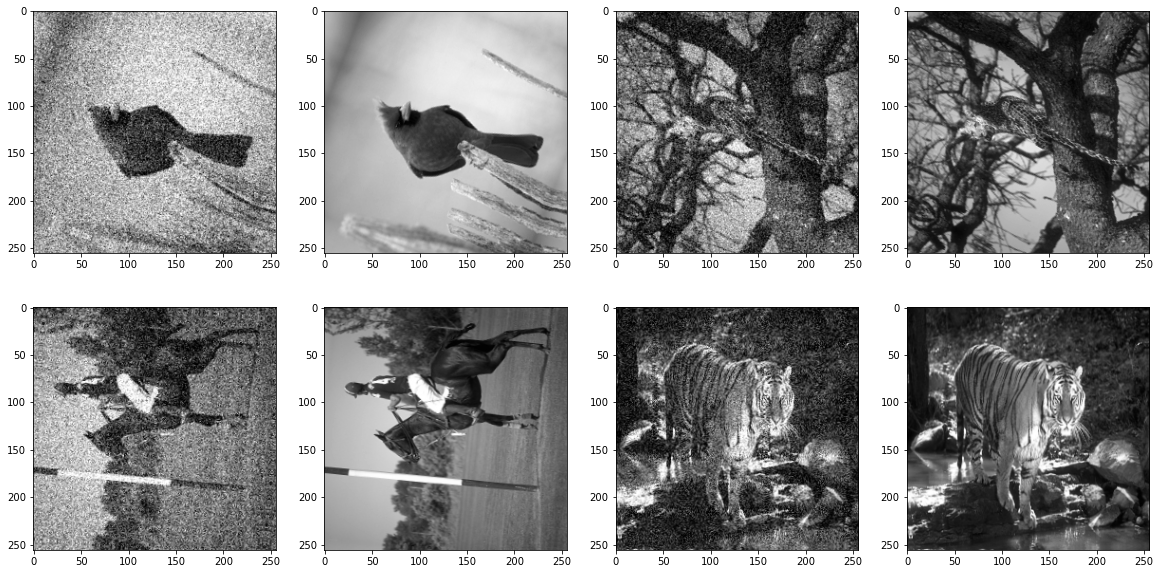

In [6]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [6]:
def loss(y_true,y_pred):
    error = tf.maximum(0.,1/tf.image.psnr(y_true,y_pred,1))
    error += (1-tf.image.ssim(y_true,y_pred,1))
    error += tf.maximum(0.,tf.math.log(tf.keras.losses.MeanSquaredError()(y_true,y_pred)))
    return error

In [ ]:


gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=7,CROP1=CROP,BATCH_SIZE=32)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=loss,)
    #model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/dectaylor_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=30,
        steps_per_epoch=50,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/dectaylor_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    



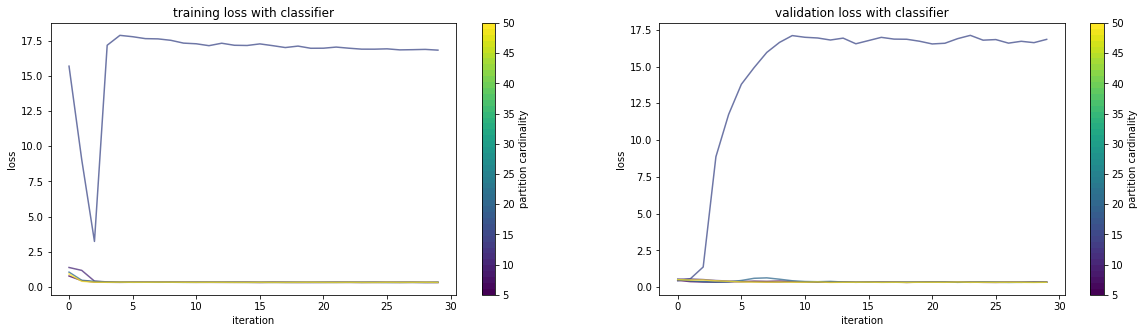

In [5]:
trained = glob(f'./history/dectaylor_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss with classifier")
axs[1].set_title("validation loss with classifier")

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')
    
plt.show()



# Results

# Results with first function

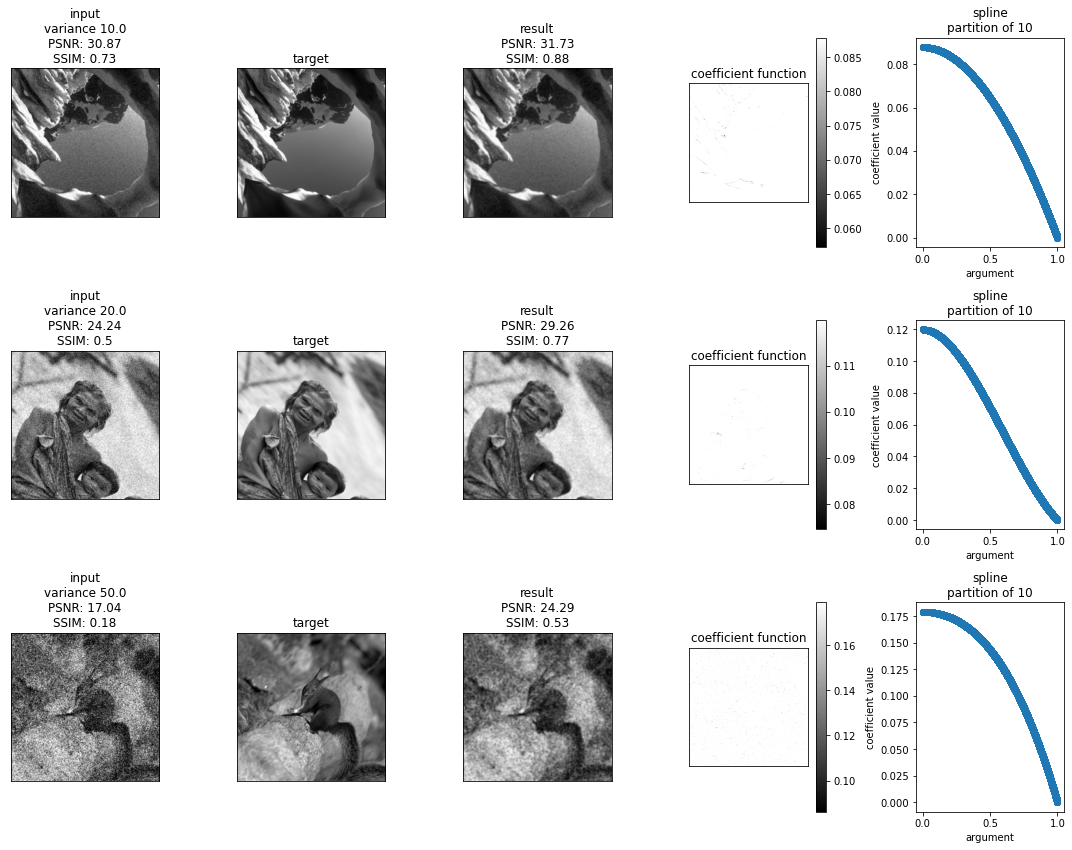

In [13]:
num_classes = 10
model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")

w = [10,20,50]
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=w[i],var1_u=w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = model(ims[0])
    _ = np.random.choice(len(p))


    psnr_0 = tf.image.psnr(ims[0][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
    get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
    get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)
    
    cte = np.squeeze(get_cte(ims[0])[_])
    linear = np.squeeze(get_linear(ims[0])[_])
    quad = np.squeeze(get_quad(ims[0])[_])
    
    visualization = tf.keras.models.Model(model.input,model.get_layer('gS_0').output)
    vis = np.squeeze(visualization(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    
    x = np.linspace(0,1,10000)
    x1 = np.power(np.expand_dims(x,axis=-1),np.expand_dims(np.arange(2,num_classes,1),axis=0))
    quad_val = np.sum(np.multiply(np.array([quad]),x1),axis=-1)
    linear_val = linear*x
    
    s = cte -linear_val + quad_val
    
    
    axs[i,4].scatter(x,s)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

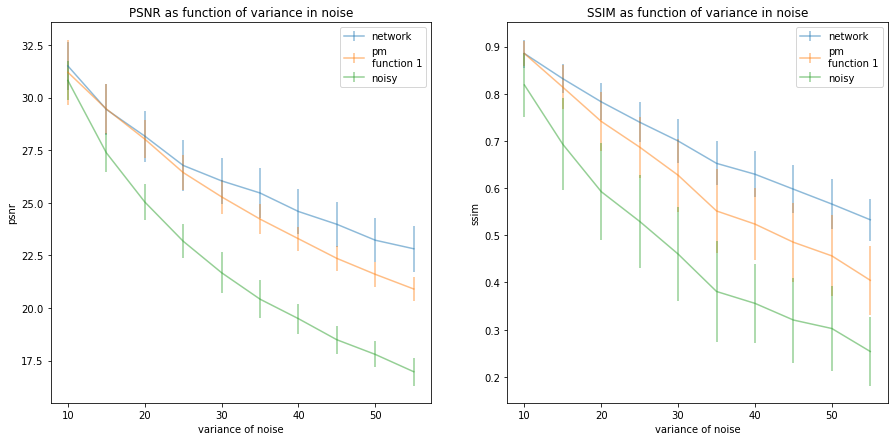

In [6]:
num_classes = 50
model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")

w = np.linspace(10,55,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
    
    psnr_nn_1.append([])
    psnr_nn_s_1.append([])
    ssim_nn_1.append([])
    ssim_nn_s_1.append([])
    psnr_pm_1.append([])
    psnr_pm_s_1.append([])
    ssim_pm_1.append([])
    ssim_pm_s_1.append([])
    psnr_or_1.append([])
    psnr_or_s_1.append([])
    ssim_or_1.append([])
    ssim_or_s_1.append([])
    
    for it in range(10):
        ims = next(gen_batch_val.as_numpy_iterator())

        res = model(ims[0])
        psnr = tf.image.psnr(res,ims[1],1).numpy()
        ssim = tf.image.ssim(res,ims[1],1).numpy()
        psnr_nn_1[-1].append(np.copy(psnr))
        psnr_nn_s_1[-1].append(np.copy(psnr))
        ssim_nn_1[-1].append(np.copy(ssim))
        ssim_nn_s_1[-1].append(np.copy(ssim))

        pm = np.array([anisodiff(im,niter = 3,lambd=50) for im in ims[0]['input']])
        pm = np.asarray(pm,dtype='float32')
        psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_pm_1[-1].append(np.copy(psnr))
        psnr_pm_s_1[-1].append(np.copy(psnr))
        ssim_pm_1[-1].append(np.copy(ssim))
        ssim_pm_s_1[-1].append(np.copy(ssim))

        psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
        ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
        psnr_or_1[-1].append(np.copy(psnr))
        psnr_or_s_1[-1].append(np.copy(psnr))
        ssim_or_1[-1].append(np.copy(ssim))
        ssim_or_s_1[-1].append(np.copy(ssim))
        
    psnr_nn_1[-1] = np.concatenate(psnr_nn_1[-1])
    psnr_nn_s_1[-1] = np.concatenate(psnr_nn_s_1[-1])
    ssim_nn_1[-1] = np.concatenate(ssim_nn_1[-1])
    ssim_nn_s_1[-1] = np.concatenate(ssim_nn_s_1[-1])
    
    psnr_pm_1[-1] = np.concatenate(psnr_pm_1[-1])
    psnr_pm_s_1[-1] = np.concatenate(psnr_pm_s_1[-1])
    ssim_pm_1[-1] = np.concatenate(ssim_pm_1[-1])
    ssim_pm_s_1[-1] = np.concatenate(ssim_pm_s_1[-1])
    
    psnr_or_1[-1] = np.concatenate(psnr_or_1[-1])
    psnr_or_s_1[-1] = np.concatenate(psnr_or_s_1[-1])
    ssim_or_1[-1] = np.concatenate(ssim_or_1[-1])
    ssim_or_s_1[-1] = np.concatenate(ssim_or_s_1[-1])
    
    


psnr_nn_1 = np.mean(psnr_nn_1,axis=-1)
psnr_nn_s_1 = np.std(psnr_nn_s_1,axis=-1)
ssim_nn_1 = np.mean(ssim_nn_1,axis=-1)
ssim_nn_s_1 = np.std(ssim_nn_s_1,axis=-1)
psnr_pm_1 = np.mean(psnr_pm_1,axis=-1)
psnr_pm_s_1 = np.std(psnr_pm_s_1,axis=-1)
ssim_pm_1 = np.mean(ssim_pm_1,axis=-1)
ssim_pm_s_1 = np.std(ssim_pm_s_1,axis=-1)
psnr_or_1 = np.mean(psnr_or_1,axis=-1)
psnr_or_s_1 = np.std(psnr_or_s_1,axis=-1)
ssim_or_1 = np.mean(ssim_or_1,axis=-1)
ssim_or_s_1 = np.std(ssim_or_s_1,axis=-1)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

/tmp/ipykernel_1305888/2227381328.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ims = np.array(next(gen_batch_val.as_numpy_iterator()))


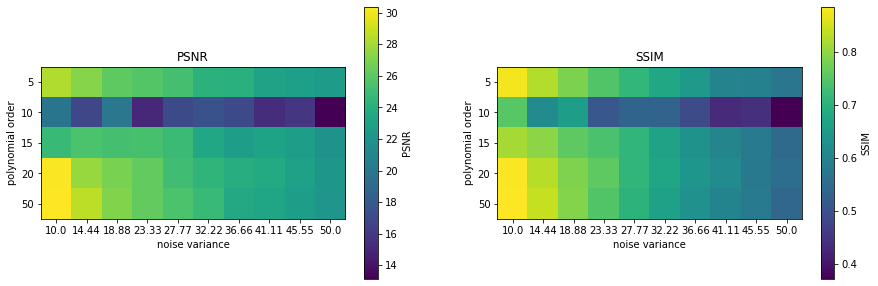

In [16]:
w = np.linspace(10,50,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dectaylor_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=100)
        
        psnr_nn_1.append([])
        ssim_nn_1.append([])
        for it in range(1):
            ims = np.array(next(gen_batch_val.as_numpy_iterator()))

            res = model(ims[0])
            res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
            psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            psnr_nn_1[-1].append(psnr)
            ssim_nn_1[-1].append(ssim)
            
        psnr_nn_1[-1] = np.mean(psnr_nn_1[-1])
        ssim_nn_1[-1] = np.mean(ssim_nn_1[-1])


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('polynomial order')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('polynomial order')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [7]:
w = np.linspace(10,50,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dectaylor_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
    model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
    get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
    get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
    get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)
    
    R.append([])
    xR.append([])
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=100)
        
        cte,linear,quad = [],[],[]
        for it in range(1):
        
            ims = next(gen_batch_val.as_numpy_iterator())
            cte.append(np.squeeze(get_cte(ims[0])))
            linear.append(np.squeeze(get_linear(ims[0])))
            quad.append(np.squeeze(get_quad(ims[0])))
        
        cte = np.concatenate(cte,axis=0)
        cte = np.mean(cte,axis=0)
        linear = np.concatenate(linear,axis=0)
        linear = np.mean(linear,axis=0)
        quad = np.concatenate(quad,axis=0)
        quad = np.mean(quad,axis=0)

        
        x = np.linspace(0,1,10000)
        x1 = np.power(np.expand_dims(x,axis=-1),np.expand_dims(np.arange(2,num_classes,1),axis=0))
        quad_val = np.sum(np.multiply(np.array([quad]),x1),axis=-1)
        linear_val = linear*x

        s = cte -linear_val + quad_val
    
    
        R[-1].append(np.copy(s))
        xR[-1].append(np.copy(x))
        
R = np.array(R)

2023-02-21 16:31:51.923516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2023-02-21 16:31:52.952257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


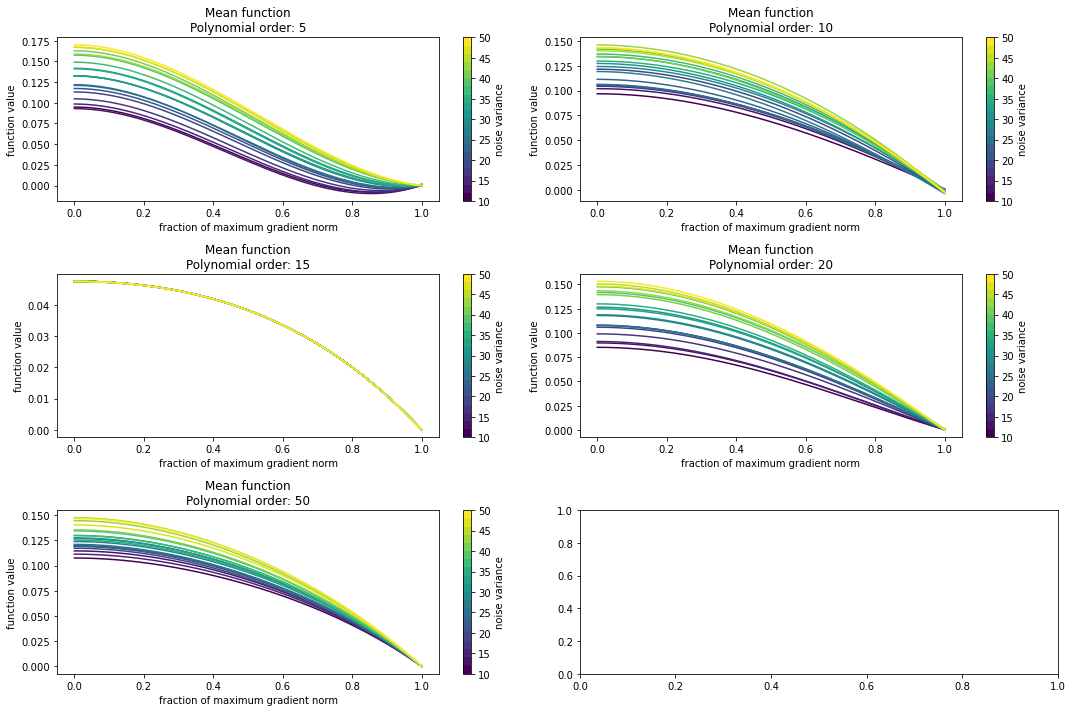

In [8]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(xR[col][i],R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nPolynomial order: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("fraction of maximum gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# umap

In [24]:
w = np.linspace(10,50,10)
num_classes = 5
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

img,noisy = [],[]

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=250)

    cte,linear,quad = [],[],[]
    for it in range(4):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))
        
        noisy.append(np.copy(ims[0]['input']))
        img.append(np.copy(ims[1]))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))
    
psnr = tf.image.psnr(np.concatenate(img),np.concatenate(noisy),1)
min_psnr = np.amin(psnr)
psnr = psnr - min_psnr
max_psnr = np.amax(psnr)
psnr = np.asarray(100*psnr/max_psnr,dtype='int')

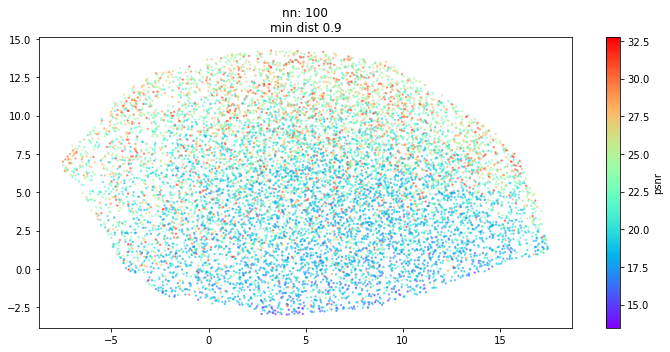

In [53]:
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

plt.figure(figsize=(10,5))
reducer = umap.UMAP(n_neighbors=100,min_dist=0.9)
embedding = reducer.fit_transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.title(f'nn: 100\nmin dist 0.9')        
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='psnr')

plt.tight_layout()
plt.show()

In [54]:
w = np.linspace(10,50,10)
num_classes = 20
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

img,noisy = [],[]

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=250)

    cte,linear,quad = [],[],[]
    for it in range(4):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))
        
        noisy.append(np.copy(ims[0]['input']))
        img.append(np.copy(ims[1]))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))
    
psnr = tf.image.psnr(np.concatenate(img),np.concatenate(noisy),1)
min_psnr = np.amin(psnr)
psnr = psnr - min_psnr
max_psnr = np.amax(psnr)
psnr = np.asarray(100*psnr/max_psnr,dtype='int')

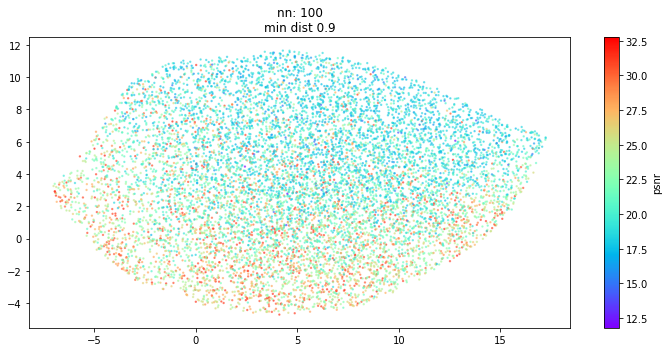

In [56]:
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

plt.figure(figsize=(10,5))
reducer = umap.UMAP(n_neighbors=500,min_dist=1)
embedding = reducer.fit_transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.title(f'nn: 100\nmin dist 0.9')        
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='psnr')

plt.tight_layout()
plt.show()

In [79]:
w = np.linspace(10,50,10)
num_classes = 50
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

img,noisy = [],[]

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=250)

    cte,linear,quad = [],[],[]
    for it in range(4):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))
        
        noisy.append(np.copy(ims[0]['input']))
        img.append(np.copy(ims[1]))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))
    
psnr = tf.image.psnr(np.concatenate(img),np.concatenate(noisy),1)
min_psnr = np.amin(psnr)
psnr = psnr - min_psnr
max_psnr = np.amax(psnr)
psnr = np.asarray(100*psnr/max_psnr,dtype='int')

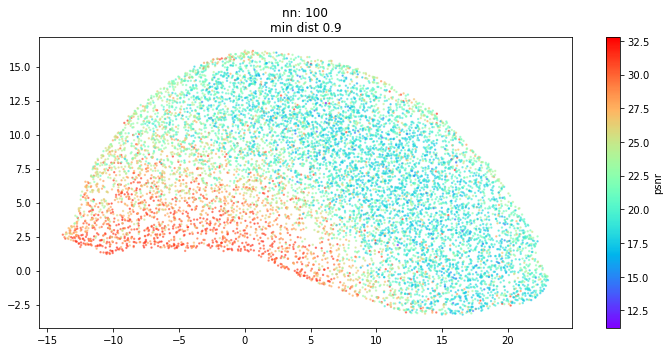

In [80]:
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

plt.figure(figsize=(10,5))
reducer = umap.UMAP(n_neighbors=500,min_dist=1)
embedding = reducer.fit_transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.title(f'nn: 100\nmin dist 0.9')        
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='psnr')

plt.tight_layout()
plt.show()

# PCA

In [62]:
w = np.linspace(10,50,10)
num_classes = 5
C,L,Q = [],[],[]

img,noisy = [],[]

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=250)

    cte,linear,quad = [],[],[]
    for it in range(4):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))
        
        noisy.append(np.copy(ims[0]['input']))
        img.append(np.copy(ims[1]))


    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))
    
psnr = tf.image.psnr(np.concatenate(img),np.concatenate(noisy),1)
min_psnr = np.amin(psnr)
psnr = psnr - min_psnr
max_psnr = np.amax(psnr)
psnr = np.asarray(100*psnr/max_psnr,dtype='int')

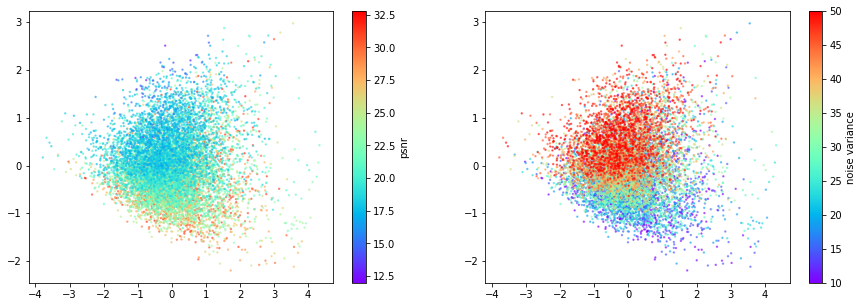

In [78]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
pca = PCA(n_components = 2)
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
#c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])
pca.fit(X1)
embedding = pca.transform(X1)


#colors = cm.rainbow(np.linspace(0,1,len(X)))
#c = colors[np.asarray(c,dtype='int')]
plt.figure(figsize=(15,5))

plt.subplot(121)
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='psnr')

plt.subplot(122)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])
colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='noise variance')

plt.show()

In [4]:
w = np.linspace(10,50,10)
num_classes = 20
C,L,Q = [],[],[]

img,noisy = [],[]

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in tqdm(enumerate(w)):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=250)

    cte,linear,quad = [],[],[]
    for it in range(4):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))
        
        noisy.append(np.copy(ims[0]['input']))
        img.append(np.copy(ims[1]))


    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))
    

psnr = tf.image.psnr(np.concatenate(img),np.concatenate(noisy),1)
min_psnr = np.amin(psnr)
psnr = psnr - min_psnr
max_psnr = np.amax(psnr)
psnr = np.asarray(100*psnr/max_psnr,dtype='int')

10it [02:34, 15.42s/it]


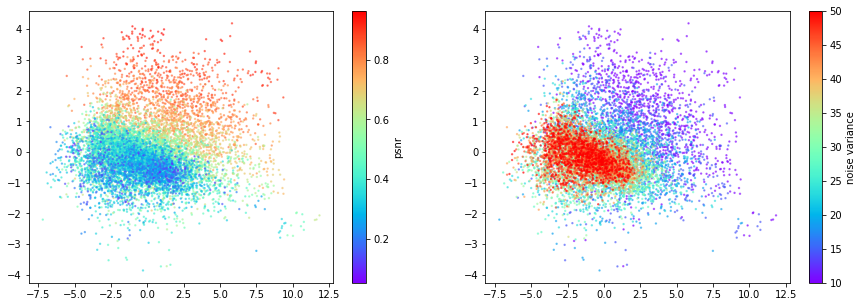

In [10]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
pca = PCA(n_components = 2)
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
pca.fit(X1)
embedding = pca.transform(X1)


plt.figure(figsize=(15,5))

plt.subplot(121)
colors = cm.rainbow(np.linspace(0,1,101))
c = colors[psnr]
norm = mpl.colors.Normalize(vmin=min_psnr, vmax=max_psnr+min_psnr)

plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='psnr')

plt.subplot(122)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])
colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='noise variance')

plt.show()

# Plot the model

In [13]:
model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = 5)

In [14]:
tf.keras.utils.plot_model(model,
    to_file="taylor.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_keras_history'

# Inverse image

In [4]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=0.5,CROP1=CROP,BATCH_SIZE=100)
x,y = next(gen_batch_train.as_numpy_iterator())

In [3]:
num_classes = 5

model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

In [5]:


"""
Creating the model
"""
def conv_block(x, n_filt, size_conv=(5,5), n_conv=3):
    """
    Applies n_conv convolutions to the input with specified size and number of filters.
    """
    for c in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filt, size_conv, padding="same", activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def u_encoder(x, n_filt):
    """
    Applies conv_block and returnes max pooled and skip-connection.
    """
    x = conv_block(x, n_filt)
    return tf.keras.layers.MaxPool2D()(x), x

def u_decoder(pooled, skipped, n_filt):
    """
    Upsamples pooled and concats with skiped.
    """
    upsampled = tf.keras.layers.Convolution2DTranspose(n_filt, (2,2), strides=(2,2), padding='same')(pooled)
    return conv_block(tf.keras.layers.concatenate([upsampled, skipped]), n_filt)
    
    
def make_unet(inp, depth=3, output_channels=1):
    skipped = []
    p = inp
    for _ in range(depth):
        p, s = u_encoder(p, 2**(1+_))
        skipped.append(s)
    p = conv_block(p, 2**(2+depth))
    for _ in reversed(range(depth)):
        p = u_decoder(p, skipped[_], 2**(2+_))  
    p = tf.keras.layers.Conv2D(output_channels, (1,1), activation='sigmoid')(p)
    return p

def get_unet(inp):
    """
    Takes network Input layer 
    """
    outp = make_unet(inp)
    
    return outp

In [6]:
def get_search(inp):
    x = get_unet(inp)
    x = tf.keras.layers.Dense(1,activation = 'sigmoid',name='image')(x)
    
    variance = tf.keras.layers.Flatten()(inp)
    variance = tf.keras.layers.Dense(1,activation="relu",name='variance')(variance)
    
    for layer in get_cte.layers:
        layer.trainable = False
        
    for layer in get_linear.layers:
        layer.trainable = False
        
    for layer in get_quad.layers:
        layer.trainable = False
        
    cte = get_cte({'input':x,'input_emb':variance})
    linear = get_linear({'input':x,'input_emb':variance})
    quad = get_quad({'input':x,'input_emb':variance})
    
    output = tf.keras.layers.concatenate((cte,linear,quad))
    
    return tf.keras.models.Model(inp, output)

In [21]:
for entry in range(num_classes):
    print(entry)

    X = np.ones((100,CROP,CROP,1))
    Y = np.zeros((len(X),num_classes))
    Y[...,entry] = 1

    search = get_search(tf.keras.Input((CROP,CROP,1)))
    search.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss='mse',)

    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/preimage{entry}_{typ}_{num_classes}",
        save_weights_only=True,
        verbose = True,
        save_best_only=True,
        monitor = 'loss'),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
        ]


    history = search.fit(x=X,y=Y,
        epochs=250,
        shuffle=False,
        use_multiprocessing=True,
        workers=1,
        callbacks=callbacks
    )

0
Epoch 1/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5537
Epoch 00001: loss improved from inf to 0.54683, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 4s 156ms/step - loss: 0.5468 - lr: 0.0010
Epoch 2/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3057
Epoch 00002: loss improved from 0.54683 to 0.30387, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.3039 - lr: 0.0010
Epoch 3/250
3/4 [=====================>........] - ETA: 0s - loss: 0.2086
Epoch 00003: loss improved from 0.30387 to 0.20775, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.2077 - lr: 0.0010
Epoch 4/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1720
Epoch 00004: loss improved from 0.20775 to 0.17158, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 158ms/ste

4/4 [==============================] - 1s 166ms/step - loss: 0.1019 - lr: 0.0010
Epoch 33/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1014
Epoch 00033: loss improved from 0.10192 to 0.10143, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.1014 - lr: 0.0010
Epoch 34/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1010
Epoch 00034: loss improved from 0.10143 to 0.10097, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.1010 - lr: 0.0010
Epoch 35/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1005
Epoch 00035: loss improved from 0.10097 to 0.10051, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.1005 - lr: 0.0010
Epoch 36/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1001
Epoch 00036: loss improved from 0.10051 to 0.10008, saving model to

4/4 [==============================] - 1s 163ms/step - loss: 0.0922 - lr: 0.0010
Epoch 65/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0919
Epoch 00065: loss improved from 0.09218 to 0.09190, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.0919 - lr: 0.0010
Epoch 66/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0916
Epoch 00066: loss improved from 0.09190 to 0.09158, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.0916 - lr: 0.0010
Epoch 67/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0913
Epoch 00067: loss improved from 0.09158 to 0.09128, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.0913 - lr: 0.0010
Epoch 68/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0910
Epoch 00068: loss improved from 0.09128 to 0.09100, saving model to

Epoch 133/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0801
Epoch 00133: loss improved from 0.08038 to 0.08013, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.0801 - lr: 0.0010
Epoch 134/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0799
Epoch 00134: loss improved from 0.08013 to 0.07986, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 154ms/step - loss: 0.0799 - lr: 0.0010
Epoch 135/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0801
Epoch 00135: loss did not improve from 0.07986
4/4 [==============================] - 0s 103ms/step - loss: 0.0801 - lr: 0.0010
Epoch 136/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0802
Epoch 00136: loss did not improve from 0.07986
4/4 [==============================] - 0s 105ms/step - loss: 0.0802 - lr: 0.0010
Epoch 137/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0

3/4 [=====================>........] - ETA: 0s - loss: 0.0763
Epoch 00169: loss improved from 0.07659 to 0.07627, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.0763 - lr: 0.0010
Epoch 170/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0761
Epoch 00170: loss improved from 0.07627 to 0.07612, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 162ms/step - loss: 0.0761 - lr: 0.0010
Epoch 171/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0759
Epoch 00171: loss improved from 0.07612 to 0.07589, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.0759 - lr: 0.0010
Epoch 172/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0758
Epoch 00172: loss improved from 0.07589 to 0.07583, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 166ms/step - 

Epoch 206/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0744
Epoch 00206: loss did not improve from 0.07422
4/4 [==============================] - 0s 106ms/step - loss: 0.0743 - lr: 0.0010
Epoch 207/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0742
Epoch 00207: loss did not improve from 0.07422
4/4 [==============================] - 0s 106ms/step - loss: 0.0742 - lr: 0.0010
Epoch 208/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0740
Epoch 00208: loss improved from 0.07422 to 0.07397, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 171ms/step - loss: 0.0740 - lr: 0.0010
Epoch 209/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0738
Epoch 00209: loss improved from 0.07397 to 0.07381, saving model to ./checkpoints/preimage0_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.0738 - lr: 0.0010
Epoch 210/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0

Epoch 243/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0757
Epoch 00243: loss did not improve from 0.07249
4/4 [==============================] - 0s 106ms/step - loss: 0.0757 - lr: 0.0010
Epoch 244/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0753
Epoch 00244: loss did not improve from 0.07249
4/4 [==============================] - 0s 105ms/step - loss: 0.0753 - lr: 0.0010
Epoch 245/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0752
Epoch 00245: loss did not improve from 0.07249
4/4 [==============================] - 0s 104ms/step - loss: 0.0751 - lr: 0.0010
Epoch 246/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0748
Epoch 00246: loss did not improve from 0.07249
4/4 [==============================] - 0s 107ms/step - loss: 0.0748 - lr: 0.0010
Epoch 247/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0744
Epoch 00247: loss did not improve from 0.07249
4/4 [==============================] - 0s 105ms/step - loss: 

4/4 [==============================] - 1s 168ms/step - loss: 0.4891 - lr: 0.0010
Epoch 27/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4799
Epoch 00027: loss improved from 0.48908 to 0.47978, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.4798 - lr: 0.0010
Epoch 28/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4714
Epoch 00028: loss improved from 0.47978 to 0.47121, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.4712 - lr: 0.0010
Epoch 29/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4618
Epoch 00029: loss improved from 0.47121 to 0.46169, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.4617 - lr: 0.0010
Epoch 30/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4535
Epoch 00030: loss improved from 0.46169 to 0.45336, saving model to

4/4 [==============================] - 1s 169ms/step - loss: 0.2914 - lr: 0.0010
Epoch 59/250
3/4 [=====================>........] - ETA: 0s - loss: 0.2857
Epoch 00059: loss improved from 0.29143 to 0.28563, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 0.2856 - lr: 0.0010
Epoch 60/250
3/4 [=====================>........] - ETA: 0s - loss: 0.2833
Epoch 00060: loss improved from 0.28563 to 0.28316, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 172ms/step - loss: 0.2832 - lr: 0.0010
Epoch 61/250
3/4 [=====================>........] - ETA: 0s - loss: 0.2785
Epoch 00061: loss improved from 0.28316 to 0.27828, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.2783 - lr: 0.0010
Epoch 62/250
3/4 [=====================>........] - ETA: 0s - loss: 0.2742
Epoch 00062: loss improved from 0.27828 to 0.27408, saving model to

4/4 [==============================] - 1s 171ms/step - loss: 0.1844 - lr: 0.0010
Epoch 91/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1826
Epoch 00091: loss improved from 0.18436 to 0.18251, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 179ms/step - loss: 0.1825 - lr: 0.0010
Epoch 92/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1799
Epoch 00092: loss improved from 0.18251 to 0.17983, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.1798 - lr: 0.0010
Epoch 93/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1764
Epoch 00093: loss improved from 0.17983 to 0.17631, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.1763 - lr: 0.0010
Epoch 94/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1765
Epoch 00094: loss did not improve from 0.17631
4/4 [===============

4/4 [==============================] - 1s 168ms/step - loss: 0.1297 - lr: 0.0010
Epoch 123/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1283
Epoch 00123: loss improved from 0.12973 to 0.12828, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 172ms/step - loss: 0.1283 - lr: 0.0010
Epoch 124/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1274
Epoch 00124: loss improved from 0.12828 to 0.12738, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 0.1274 - lr: 0.0010
Epoch 125/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1255
Epoch 00125: loss improved from 0.12738 to 0.12555, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 170ms/step - loss: 0.1256 - lr: 0.0010
Epoch 126/250
3/4 [=====================>........] - ETA: 0s - loss: 0.1258
Epoch 00126: loss did not improve from 0.12555
4/4 [===========

Epoch 156/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0978
Epoch 00156: loss improved from 0.09868 to 0.09781, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.0978 - lr: 0.0010
Epoch 157/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0960
Epoch 00157: loss improved from 0.09781 to 0.09601, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.0960 - lr: 0.0010
Epoch 158/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0954
Epoch 00158: loss improved from 0.09601 to 0.09540, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.0954 - lr: 0.0010
Epoch 159/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0956
Epoch 00159: loss did not improve from 0.09540
4/4 [==============================] - 0s 106ms/step - loss: 0.0955 - lr: 0.0010
Epoch 160/250
3/

4/4 [==============================] - 1s 164ms/step - loss: 0.0791 - lr: 0.0010
Epoch 190/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0787
Epoch 00190: loss improved from 0.07907 to 0.07870, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.0787 - lr: 0.0010
Epoch 191/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0788
Epoch 00191: loss did not improve from 0.07870
4/4 [==============================] - 0s 105ms/step - loss: 0.0787 - lr: 0.0010
Epoch 192/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0776
Epoch 00192: loss improved from 0.07870 to 0.07759, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 0.0776 - lr: 0.0010
Epoch 193/250
3/4 [=====================>........] - ETA: 0s - loss: 0.0775
Epoch 00193: loss improved from 0.07759 to 0.07755, saving model to ./checkpoints/preimage1_gaussian_5
4/4 [===========

4/4 [==============================] - 1s 156ms/step - loss: 0.9867 - lr: 0.0010
Epoch 8/250
3/4 [=====================>........] - ETA: 0s - loss: 0.9540
Epoch 00008: loss improved from 0.98674 to 0.95343, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 170ms/step - loss: 0.9534 - lr: 0.0010
Epoch 9/250
3/4 [=====================>........] - ETA: 0s - loss: 0.9264
Epoch 00009: loss improved from 0.95343 to 0.92582, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.9258 - lr: 0.0010
Epoch 10/250
3/4 [=====================>........] - ETA: 0s - loss: 0.9008
Epoch 00010: loss improved from 0.92582 to 0.90036, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.9004 - lr: 0.0010
Epoch 11/250
3/4 [=====================>........] - ETA: 0s - loss: 0.8781
Epoch 00011: loss improved from 0.90036 to 0.87765, saving model to .

4/4 [==============================] - 1s 164ms/step - loss: 0.5954 - lr: 0.0010
Epoch 40/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5877
Epoch 00040: loss improved from 0.59544 to 0.58758, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.5876 - lr: 0.0010
Epoch 41/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5814
Epoch 00041: loss improved from 0.58758 to 0.58119, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.5812 - lr: 0.0010
Epoch 42/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5756
Epoch 00042: loss improved from 0.58119 to 0.57555, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 162ms/step - loss: 0.5756 - lr: 0.0010
Epoch 43/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5712
Epoch 00043: loss improved from 0.57555 to 0.57113, saving model to

4/4 [==============================] - 1s 161ms/step - loss: 0.4634 - lr: 0.0010
Epoch 72/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4604
Epoch 00072: loss improved from 0.46339 to 0.46019, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.4602 - lr: 0.0010
Epoch 73/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4567
Epoch 00073: loss improved from 0.46019 to 0.45660, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.4566 - lr: 0.0010
Epoch 74/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4553
Epoch 00074: loss improved from 0.45660 to 0.45526, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.4553 - lr: 0.0010
Epoch 75/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4511
Epoch 00075: loss improved from 0.45526 to 0.45105, saving model to

4/4 [==============================] - 1s 166ms/step - loss: 0.3986 - lr: 0.0010
Epoch 105/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3975
Epoch 00105: loss improved from 0.39863 to 0.39761, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 0.3976 - lr: 0.0010
Epoch 106/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3984
Epoch 00106: loss did not improve from 0.39761
4/4 [==============================] - 0s 106ms/step - loss: 0.3983 - lr: 0.0010
Epoch 107/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3955
Epoch 00107: loss improved from 0.39761 to 0.39546, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 0.3955 - lr: 0.0010
Epoch 108/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3956
Epoch 00108: loss did not improve from 0.39546
4/4 [==============================] - 0s 104ms/step - loss: 0.3955 - lr

Epoch 139/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3654
Epoch 00139: loss did not improve from 0.36532
4/4 [==============================] - 0s 104ms/step - loss: 0.3654 - lr: 0.0010
Epoch 140/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3648
Epoch 00140: loss improved from 0.36532 to 0.36483, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.3648 - lr: 0.0010
Epoch 141/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3634
Epoch 00141: loss improved from 0.36483 to 0.36343, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.3634 - lr: 0.0010
Epoch 142/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3620
Epoch 00142: loss improved from 0.36343 to 0.36199, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.3620 - lr: 0.0010
Epoch 143/250
3/

4/4 [==============================] - 1s 166ms/step - loss: 0.3334 - lr: 0.0010
Epoch 210/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3325
Epoch 00210: loss improved from 0.33338 to 0.33256, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.3326 - lr: 0.0010
Epoch 211/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3324
Epoch 00211: loss improved from 0.33256 to 0.33240, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.3324 - lr: 0.0010
Epoch 212/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3319
Epoch 00212: loss improved from 0.33240 to 0.33182, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 183ms/step - loss: 0.3318 - lr: 0.0010
Epoch 213/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3304
Epoch 00213: loss improved from 0.33182 to 0.33035, saving mode

4/4 [==============================] - 1s 164ms/step - loss: 0.3214 - lr: 0.0010
Epoch 245/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3214
Epoch 00245: loss improved from 0.32135 to 0.32135, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.3213 - lr: 0.0010
Epoch 246/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3211
Epoch 00246: loss improved from 0.32135 to 0.32107, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.3211 - lr: 0.0010
Epoch 247/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3208
Epoch 00247: loss improved from 0.32107 to 0.32076, saving model to ./checkpoints/preimage2_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.3208 - lr: 0.0010
Epoch 248/250
3/4 [=====================>........] - ETA: 0s - loss: 0.3202
Epoch 00248: loss improved from 0.32076 to 0.32017, saving mode

4/4 [==============================] - 1s 170ms/step - loss: 1.0999 - lr: 0.0010
Epoch 27/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0911
Epoch 00027: loss improved from 1.09988 to 1.09095, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 1.0909 - lr: 0.0010
Epoch 28/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0825
Epoch 00028: loss improved from 1.09095 to 1.08230, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 156ms/step - loss: 1.0823 - lr: 0.0010
Epoch 29/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0739
Epoch 00029: loss improved from 1.08230 to 1.07374, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 1.0737 - lr: 0.0010
Epoch 30/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0648
Epoch 00030: loss improved from 1.07374 to 1.06459, saving model to

4/4 [==============================] - 1s 172ms/step - loss: 0.8718 - lr: 0.0010
Epoch 59/250
3/4 [=====================>........] - ETA: 0s - loss: 0.8677
Epoch 00059: loss improved from 0.87176 to 0.86758, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 162ms/step - loss: 0.8676 - lr: 0.0010
Epoch 60/250
3/4 [=====================>........] - ETA: 0s - loss: 0.8600
Epoch 00060: loss improved from 0.86758 to 0.85989, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.8599 - lr: 0.0010
Epoch 61/250
3/4 [=====================>........] - ETA: 0s - loss: 0.8528
Epoch 00061: loss improved from 0.85989 to 0.85274, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.8527 - lr: 0.0010
Epoch 62/250
3/4 [=====================>........] - ETA: 0s - loss: 0.8489
Epoch 00062: loss improved from 0.85274 to 0.84874, saving model to

4/4 [==============================] - 1s 164ms/step - loss: 0.6987 - lr: 0.0010
Epoch 91/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6946
Epoch 00091: loss improved from 0.69873 to 0.69449, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 156ms/step - loss: 0.6945 - lr: 0.0010
Epoch 92/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6900
Epoch 00092: loss improved from 0.69449 to 0.68992, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 164ms/step - loss: 0.6899 - lr: 0.0010
Epoch 93/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6861
Epoch 00093: loss improved from 0.68992 to 0.68604, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.6860 - lr: 0.0010
Epoch 94/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6827
Epoch 00094: loss improved from 0.68604 to 0.68275, saving model to

4/4 [==============================] - 1s 163ms/step - loss: 0.5913 - lr: 0.0010
Epoch 123/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5907
Epoch 00123: loss improved from 0.59132 to 0.59069, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 193ms/step - loss: 0.5907 - lr: 0.0010
Epoch 124/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5859
Epoch 00124: loss improved from 0.59069 to 0.58586, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.5859 - lr: 0.0010
Epoch 125/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5824
Epoch 00125: loss improved from 0.58586 to 0.58227, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 248ms/step - loss: 0.5823 - lr: 0.0010
Epoch 126/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5808
Epoch 00126: loss improved from 0.58227 to 0.58069, saving mode

4/4 [==============================] - 1s 168ms/step - loss: 0.5201 - lr: 0.0010
Epoch 155/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5181
Epoch 00155: loss improved from 0.52008 to 0.51809, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 165ms/step - loss: 0.5181 - lr: 0.0010
Epoch 156/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5167
Epoch 00156: loss improved from 0.51809 to 0.51663, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 169ms/step - loss: 0.5166 - lr: 0.0010
Epoch 157/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5131
Epoch 00157: loss improved from 0.51663 to 0.51316, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 170ms/step - loss: 0.5132 - lr: 0.0010
Epoch 158/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5173
Epoch 00158: loss did not improve from 0.51316
4/4 [===========

Epoch 188/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4737
Epoch 00188: loss improved from 0.47586 to 0.47370, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 166ms/step - loss: 0.4737 - lr: 0.0010
Epoch 189/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4717
Epoch 00189: loss improved from 0.47370 to 0.47169, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 174ms/step - loss: 0.4717 - lr: 0.0010
Epoch 190/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4708
Epoch 00190: loss improved from 0.47169 to 0.47088, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 179ms/step - loss: 0.4709 - lr: 0.0010
Epoch 191/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4710
Epoch 00191: loss did not improve from 0.47088
4/4 [==============================] - 0s 106ms/step - loss: 0.4710 - lr: 0.0010
Epoch 192/250
3/

4/4 [==============================] - 1s 166ms/step - loss: 0.4438 - lr: 0.0010
Epoch 222/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4429
Epoch 00222: loss improved from 0.44382 to 0.44295, saving model to ./checkpoints/preimage3_gaussian_5
4/4 [==============================] - 1s 178ms/step - loss: 0.4430 - lr: 0.0010
Epoch 223/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4431
Epoch 00223: loss did not improve from 0.44295
4/4 [==============================] - 0s 110ms/step - loss: 0.4432 - lr: 0.0010
Epoch 224/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4466
Epoch 00224: loss did not improve from 0.44295
4/4 [==============================] - 0s 106ms/step - loss: 0.4464 - lr: 0.0010
Epoch 225/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4445
Epoch 00225: loss did not improve from 0.44295
4/4 [==============================] - 0s 106ms/step - loss: 0.4444 - lr: 0.0010
Epoch 226/250
3/4 [=====================>......

4/4 [==============================] - 1s 165ms/step - loss: 1.2211 - lr: 0.0010
Epoch 6/250
3/4 [=====================>........] - ETA: 0s - loss: 1.1423
Epoch 00006: loss improved from 1.22112 to 1.14082, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 168ms/step - loss: 1.1408 - lr: 0.0010
Epoch 7/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0700
Epoch 00007: loss improved from 1.14082 to 1.06873, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 177ms/step - loss: 1.0687 - lr: 0.0010
Epoch 8/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0114
Epoch 00008: loss improved from 1.06873 to 1.01076, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 158ms/step - loss: 1.0108 - lr: 0.0010
Epoch 9/250
3/4 [=====================>........] - ETA: 0s - loss: 1.0028
Epoch 00009: loss improved from 1.01076 to 1.00220, saving model to ./c

4/4 [==============================] - 1s 168ms/step - loss: 0.6891 - lr: 0.0010
Epoch 38/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6840
Epoch 00038: loss improved from 0.68911 to 0.68387, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 156ms/step - loss: 0.6839 - lr: 0.0010
Epoch 39/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6755
Epoch 00039: loss improved from 0.68387 to 0.67541, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 167ms/step - loss: 0.6754 - lr: 0.0010
Epoch 40/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6699
Epoch 00040: loss improved from 0.67541 to 0.66979, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.6698 - lr: 0.0010
Epoch 41/250
3/4 [=====================>........] - ETA: 0s - loss: 0.6640
Epoch 00041: loss improved from 0.66979 to 0.66390, saving model to

Epoch 70/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5603
Epoch 00070: loss improved from 0.56285 to 0.56024, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.5602 - lr: 0.0010
Epoch 71/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5568
Epoch 00071: loss improved from 0.56024 to 0.55667, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 173ms/step - loss: 0.5567 - lr: 0.0010
Epoch 72/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5531
Epoch 00072: loss improved from 0.55667 to 0.55299, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 172ms/step - loss: 0.5530 - lr: 0.0010
Epoch 73/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5498
Epoch 00073: loss improved from 0.55299 to 0.54978, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 176

4/4 [==============================] - 1s 159ms/step - loss: 0.5067 - lr: 0.0010
Epoch 103/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5050
Epoch 00103: loss improved from 0.50670 to 0.50499, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 172ms/step - loss: 0.5050 - lr: 0.0010
Epoch 104/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5046
Epoch 00104: loss improved from 0.50499 to 0.50456, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 170ms/step - loss: 0.5046 - lr: 0.0010
Epoch 105/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5053
Epoch 00105: loss did not improve from 0.50456
4/4 [==============================] - 0s 103ms/step - loss: 0.5053 - lr: 0.0010
Epoch 106/250
3/4 [=====================>........] - ETA: 0s - loss: 0.5029
Epoch 00106: loss improved from 0.50456 to 0.50290, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [===========

Epoch 136/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4823
Epoch 00136: loss improved from 0.48340 to 0.48236, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 171ms/step - loss: 0.4824 - lr: 0.0010
Epoch 137/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4824
Epoch 00137: loss did not improve from 0.48236
4/4 [==============================] - 0s 103ms/step - loss: 0.4824 - lr: 0.0010
Epoch 138/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4822
Epoch 00138: loss improved from 0.48236 to 0.48218, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 172ms/step - loss: 0.4822 - lr: 0.0010
Epoch 139/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4817
Epoch 00139: loss improved from 0.48218 to 0.48166, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 171ms/step - loss: 0.4817 - lr: 0.0010
Epoch 140/250
3/

Epoch 170/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4651
Epoch 00170: loss improved from 0.46555 to 0.46503, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 171ms/step - loss: 0.4650 - lr: 0.0010
Epoch 171/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4637
Epoch 00171: loss improved from 0.46503 to 0.46374, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 171ms/step - loss: 0.4637 - lr: 0.0010
Epoch 172/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4638
Epoch 00172: loss did not improve from 0.46374
4/4 [==============================] - 0s 104ms/step - loss: 0.4638 - lr: 0.0010
Epoch 173/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4646
Epoch 00173: loss did not improve from 0.46374
4/4 [==============================] - 0s 104ms/step - loss: 0.4646 - lr: 0.0010
Epoch 174/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4

4/4 [==============================] - 1s 173ms/step - loss: 0.4524 - lr: 0.0010
Epoch 205/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4519
Epoch 00205: loss improved from 0.45242 to 0.45187, saving model to ./checkpoints/preimage4_gaussian_5
4/4 [==============================] - 1s 170ms/step - loss: 0.4519 - lr: 0.0010
Epoch 206/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4534
Epoch 00206: loss did not improve from 0.45187
4/4 [==============================] - 0s 105ms/step - loss: 0.4534 - lr: 0.0010
Epoch 207/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4529
Epoch 00207: loss did not improve from 0.45187
4/4 [==============================] - 0s 104ms/step - loss: 0.4529 - lr: 0.0010
Epoch 208/250
3/4 [=====================>........] - ETA: 0s - loss: 0.4528
Epoch 00208: loss did not improve from 0.45187
4/4 [==============================] - 0s 104ms/step - loss: 0.4528 - lr: 0.0010
Epoch 209/250
3/4 [=====================>......

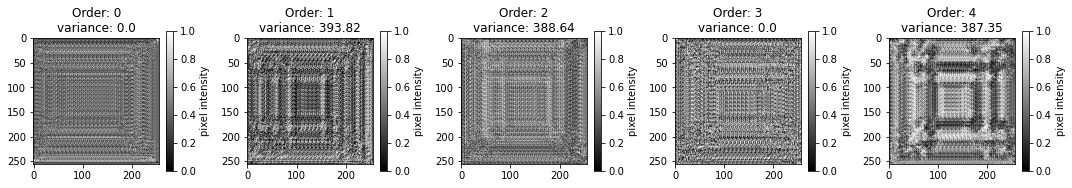

In [33]:
fig,axs = plt.subplots(ncols=num_classes,figsize=(15,5))
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for i in range(num_classes):
    search = get_search(tf.keras.Input((CROP,CROP,1)))
    search.load_weights(f"./checkpoints/preimage{i}_{typ}_{num_classes}")
    
    get_image = tf.keras.models.Model(search.input,search.get_layer('image').output)
    get_variance = tf.keras.models.Model(search.input,search.get_layer('variance').output)
    
    im = get_image(X)
    axs[i].imshow(np.squeeze(im[0]),cmap='gray')
    axs[i].set_title(f'Order: {i}\nvariance: {int(get_variance(X)[0][0]*100)/100}')
    plt.colorbar(cm.ScalarMappable(norm=norm,cmap='gray'),ax=axs[i],label='pixel intensity',fraction=0.05)
    
plt.tight_layout()
plt.show()

In [59]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=5,CROP1=CROP,BATCH_SIZE=300)
x,y = next(gen_batch_train.as_numpy_iterator())

In [34]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components = num_classes)
pca.fit(np.reshape(x['input'],(300,CROP**2)))

eigenpedestrians = pca.components_
eigenpedestrians = np.reshape(eigenpedestrians,(num_classes,CROP,CROP,1))

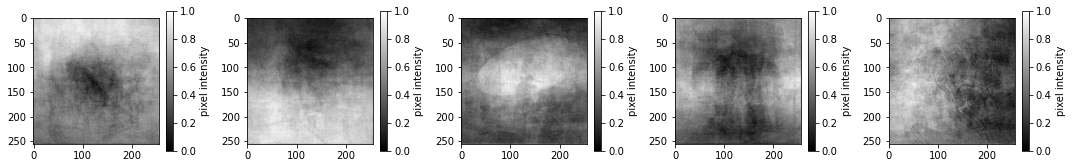

In [61]:
fig,axs = plt.subplots(ncols=num_classes,figsize=(15,5))
for i,j in enumerate(eigenpedestrians):
    axs[i].imshow(np.squeeze(j),cmap='gray')
    plt.colorbar(cm.ScalarMappable(norm=norm,cmap='gray'),ax=axs[i],label='pixel intensity',fraction=0.05)
    
plt.tight_layout()
plt.show()

In [62]:
cte = get_cte({'input':eigenpedestrians,'input_emb':0.5*np.ones((num_classes,1))})
linear = get_linear({'input':eigenpedestrians,'input_emb':0.5*np.ones((num_classes,1))})
quad = get_quad({'input':eigenpedestrians,'input_emb':0.5*np.ones((num_classes,1))})

In [64]:
poly = np.concatenate((cte,linear,quad),axis=-1)
